<a href="https://colab.research.google.com/github/waleedx1/ML-Projects/blob/main/load_prediction_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.6 MB/s eta 0:00:00


<ipython-input-2-a4f027c562fb>:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start="2020-01-01", periods=8760, freq="H")


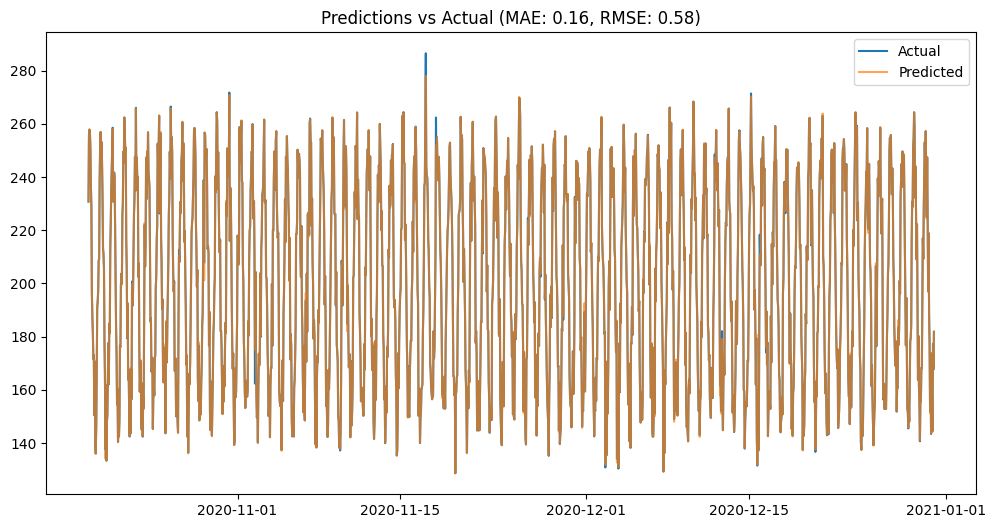

Optimized XGBoost MAE: 0.1566, RMSE: 0.5838

Top 5 Prediction Errors:
                DateTime     Load_MW   predicted      error
7730 2020-11-18 02:00:00  262.385054  251.844772  10.540282
7709 2020-11-17 05:00:00  286.544488  278.032135   8.512353
8399 2020-12-15 23:00:00  218.327526  210.876129   7.451397
7251 2020-10-29 03:00:00  207.859757  201.150406   6.709351
8317 2020-12-12 13:00:00  161.682720  157.896027   3.786694


<ipython-input-2-a4f027c562fb>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted"] = best_model.predict(X_test)
<ipython-input-2-a4f027c562fb>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["error"] = test["Load_MW"] - test["predicted"]


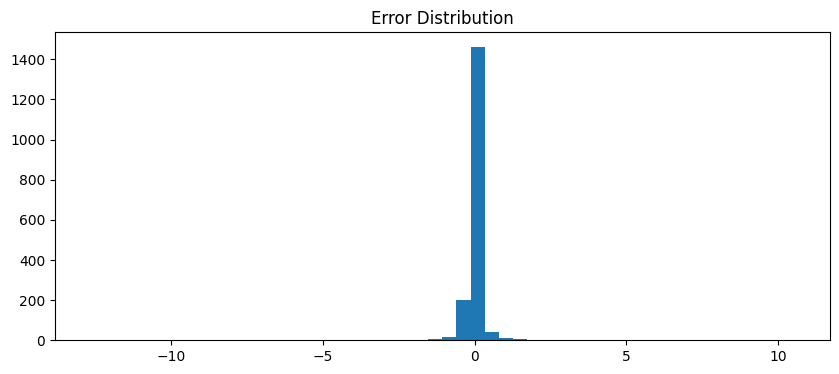

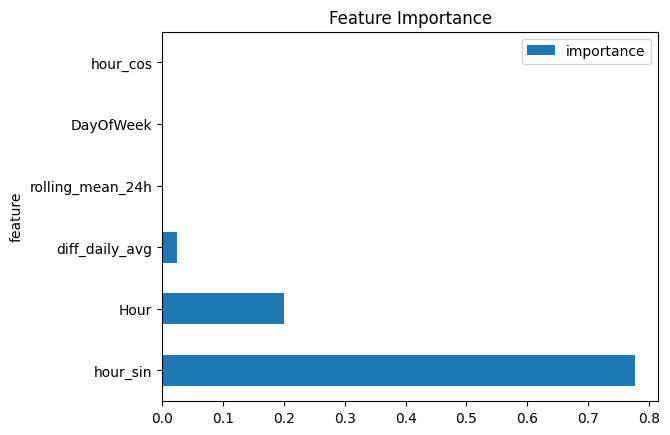

In [2]:
# ======================
# 1. Install & Import
# ======================
!pip install xgboost lightgbm scikit-optimize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from skopt import BayesSearchCV  # Bayesian optimization

# ======================
# 2. Enhanced Feature Engineering
# ======================
def create_features(df):
    # Time features
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    # Rolling features (window=24 hours)
    df['rolling_mean_24h'] = df['Load_MW'].rolling(24).mean()
    df['rolling_std_24h'] = df['Load_MW'].rolling(24).std()

    # Difference from daily average
    daily_avg = df.groupby('Hour')['Load_MW'].transform('mean')
    df['diff_daily_avg'] = df['Load_MW'] - daily_avg

    return df.dropna()

# ======================
# 3. Load & Prepare Data
# ======================
# Generate synthetic data (replace with your actual data)
dates = pd.date_range(start="2020-01-01", periods=8760, freq="H")
load = 200 + 50*np.sin(2*np.pi*np.arange(8760)/24) + np.random.normal(0, 10, 8760)
df = pd.DataFrame({"DateTime": dates, "Load_MW": load})

# Basic features
df["Hour"] = df["DateTime"].dt.hour
df["DayOfWeek"] = df["DateTime"].dt.dayofweek
df["Month"] = df["DateTime"].dt.month

# Enhanced features
df = create_features(df)

# Train-test split (time-series aware)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Features and target
features = ['Hour', 'DayOfWeek', 'hour_sin', 'hour_cos', 'rolling_mean_24h', 'diff_daily_avg']
X_train, y_train = train[features], train["Load_MW"]
X_test, y_test = test[features], test["Load_MW"]

# ======================
# 4. Optimized Model Training
# ======================
# Bayesian hyperparameter optimization for XGBoost
opt = BayesSearchCV(
    XGBRegressor(objective='reg:squarederror'),
    {
        'n_estimators': (100, 500),
        'max_depth': (3, 12),
        'learning_rate': (0.01, 0.3, 'log-uniform'),
        'subsample': (0.7, 1.0),
        'colsample_bytree': (0.7, 1.0)
    },
    n_iter=50,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_absolute_error'
)

opt.fit(X_train, y_train)
best_model = opt.best_estimator_

# ======================
# 5. Evaluation
# ======================
def evaluate(model, X_test, y_test):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))

    plt.figure(figsize=(12, 6))
    plt.plot(test["DateTime"], y_test, label="Actual")
    plt.plot(test["DateTime"], pred, label="Predicted", alpha=0.7)
    plt.title(f"Predictions vs Actual (MAE: {mae:.2f}, RMSE: {rmse:.2f})")
    plt.legend()
    plt.show()

    return mae, rmse

mae, rmse = evaluate(best_model, X_test, y_test)
print(f"Optimized XGBoost MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# ======================
# 6. Error Analysis
# ======================
test["predicted"] = best_model.predict(X_test)
test["error"] = test["Load_MW"] - test["predicted"]

# Worst predictions
print("\nTop 5 Prediction Errors:")
print(test.nlargest(5, "error")[["DateTime", "Load_MW", "predicted", "error"]])

# Error distribution
plt.figure(figsize=(10, 4))
plt.hist(test["error"], bins=50)
plt.title("Error Distribution")
plt.show()

# ======================
# 7. Feature Importance
# ======================
pd.DataFrame({
    "feature": features,
    "importance": best_model.feature_importances_
}).sort_values("importance", ascending=False).plot.barh(x="feature", y="importance")
plt.title("Feature Importance")
plt.show()